<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_15_resampling_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Description

We are continuing our efforts to predict loan defaults using the "Default of Credit Card Clients" dataset. The target variable remains highly imbalanced, with significantly more instances of non-defaults compared to defaults. Our objective is to improve the recall for the minority class (defaults) while maintaining balanced F1 and macro F1 scores. Following our experimentation with the Random Forest model, we now turn our focus to the Support Vector Machine (SVM) model.

### Previous Observations with Random Forest

Using a Random Forest model, we observed that applying random oversampling both inside and outside the pipeline resulted in improved recall for the minority class, but with a trade-off in balanced and macro F1 scores. This suggests that resampling helps the model better identify loan defaults, though it may also increase misclassifications of non-defaults.

### Experimental Approach with Support Vector Machine (SVM)

To further investigate the impact of resampling, we will experiment with an SVM model. SVMs are known for their effectiveness in high-dimensional spaces and their robustness against overfitting, particularly with proper parameter tuning.

Our experimental approach involves three main steps:

1. **Baseline Model**: Train and evaluate an SVM model without any resampling.
2. **Resampling Inside the Pipeline**: Integrate random oversampling within the pipeline and evaluate the performance.
3. **Resampling Outside the Pipeline**: Apply random oversampling before fitting the pipeline and evaluate the performance.

### Experimental Setup

#### 1. Baseline Model

We define and train a baseline SVM model without any resampling. The performance metrics (recall for class 1, balanced F1 score, and macro F1 score) are calculated using an optimal threshold of 0.25.

#### 2. Model with Resampling Inside the Pipeline

We integrate the random oversampling step within the pipeline and train the SVM model on the resampled data. This approach ensures that the resampling is applied as part of the overall pipeline workflow.

#### 3. Model with Resampling Outside the Pipeline

We apply random oversampling to the training data before fitting the pipeline. The SVM model is then trained on the resampled data, and performance metrics are calculated using the same optimal threshold.

### Evaluation and Comparison

After training and evaluating the models, we combine the results into a single DataFrame and visualize the performance metrics to compare the effectiveness of each approach. By doing so, we aim to identify whether the SVM model benefits from resampling and how it compares to the baseline model.

### Conclusion

By experimenting with an SVM model and applying resampling both inside and outside the pipeline, we aim to improve the recall for the minority class and achieve better overall performance metrics. This approach will help us understand the impact of resampling on the SVM model and guide us towards selecting the most effective strategy for handling imbalanced datasets.

### No Resampling Baseline Model

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, f1_score
from loan_data_utils import load_and_preprocess_data
import logging

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the SVM model with class weights
svm_model = SVC(random_state=42, class_weight='balanced', probability=True)

# Create the baseline pipeline
baseline_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])

# Fit the baseline pipeline to the training data
baseline_pipeline_svm.fit(X_train, y_train)

# Predict probabilities for the test data
optimal_threshold = 0.25
baseline_y_proba_svm = baseline_pipeline_svm.predict_proba(X_test)[:, 1]
baseline_y_pred_svm = (baseline_y_proba_svm >= optimal_threshold).astype(int)

# Evaluate the baseline model
baseline_recall_class1_svm = recall_score(y_test, baseline_y_pred_svm, pos_label=1)
baseline_f1_balanced_svm = f1_score(y_test, baseline_y_pred_svm, average='binary', pos_label=1)
baseline_f1_macro_svm = f1_score(y_test, baseline_y_pred_svm, average='macro')

print("Baseline SVM Model Performance with Optimal Threshold:")
print(f"Recall Class 1: {baseline_recall_class1_svm:.4f}")
print(f"F1 Score (balanced): {baseline_f1_balanced_svm:.4f}")
print(f"F1 Score (macro): {baseline_f1_macro_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, baseline_y_pred_svm))

# Save the baseline results
baseline_results_svm = {
    'Method': 'Baseline SVM',
    'Recall Class 1': baseline_recall_class1_svm,
    'F1 Score (balanced)': baseline_f1_balanced_svm,
    'F1 Score (macro)': baseline_f1_macro_svm,
    'Threshold': 'Optimal (0.25)'
}


Baseline SVM Model Performance with Optimal Threshold:
Recall Class 1: 0.5720
F1 Score (balanced): 0.5251
F1 Score (macro): 0.6872

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.57      0.53      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000



### Resampling inside Pipeline



In [4]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Define the resampling method
resampler_inside_svm = RandomOverSampler(random_state=42)

# Create the resampled pipeline
resampled_pipeline_inside_svm = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler_inside_svm),
    ('classifier', svm_model)
])

# Fit the resampled pipeline to the training data
resampled_pipeline_inside_svm.fit(X_train, y_train)

# Predict probabilities for the test data
resampled_y_proba_inside_svm = resampled_pipeline_inside_svm.predict_proba(X_test)[:, 1]
resampled_y_pred_inside_svm = (resampled_y_proba_inside_svm >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_inside_svm = recall_score(y_test, resampled_y_pred_inside_svm, pos_label=1)
resampled_f1_balanced_inside_svm = f1_score(y_test, resampled_y_pred_inside_svm, average='binary', pos_label=1)
resampled_f1_macro_inside_svm = f1_score(y_test, resampled_y_pred_inside_svm, average='macro')

print("Resampled SVM Model Performance with Optimal Threshold (Inside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_inside_svm:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_inside_svm:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_inside_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_inside_svm))

# Save the resampled results
resampled_results_inside_svm = {
    'Method': 'Random Oversampling SVM (Inside Pipeline)',
    'Recall Class 1': resampled_recall_class1_inside_svm,
    'F1 Score (balanced)': resampled_f1_balanced_inside_svm,
    'F1 Score (macro)': resampled_f1_macro_inside_svm,
    'Threshold': 'Optimal (0.25)'
}


Resampled SVM Model Performance with Optimal Threshold (Inside Pipeline):
Recall Class 1: 0.9729
F1 Score (balanced): 0.3800
F1 Score (macro): 0.2853

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.11      0.19      4673
           1       0.24      0.97      0.38      1327

    accuracy                           0.30      6000
   macro avg       0.58      0.54      0.29      6000
weighted avg       0.78      0.30      0.23      6000



### Resampling Outside Pipeline

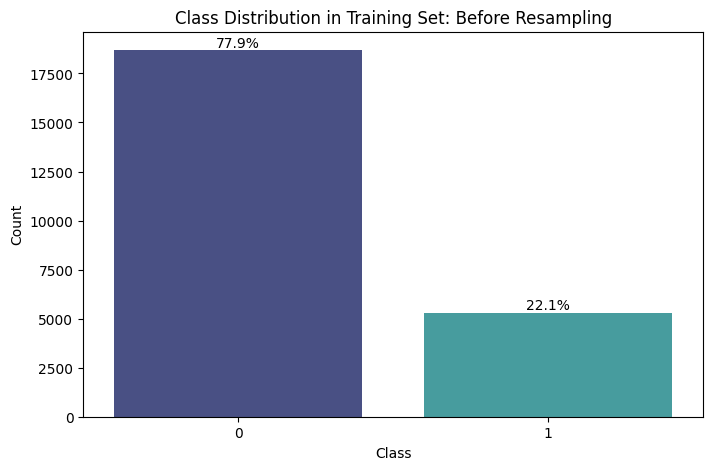

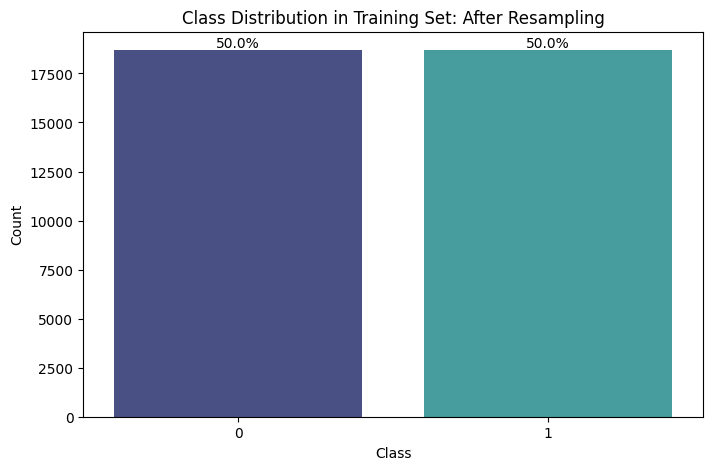

Resampled SVM Model Performance with Optimal Threshold (Outside Pipeline):
Recall Class 1: 0.9676
F1 Score (balanced): 0.3841
F1 Score (macro): 0.3048

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.13      0.23      4673
           1       0.24      0.97      0.38      1327

    accuracy                           0.31      6000
   macro avg       0.59      0.55      0.30      6000
weighted avg       0.78      0.31      0.26      6000



In [5]:
# Define the resampling method
resampler_outside_svm = RandomOverSampler(random_state=42)

# Resample the training data
X_resampled_outside_svm, y_resampled_outside_svm = resampler_outside_svm.fit_resample(X_train, y_train)

# Plot class distribution before resampling
plot_class_distribution(y_train, 'Before Resampling')

# Plot class distribution after resampling
plot_class_distribution(y_resampled_outside_svm, 'After Resampling')

# Create the pipeline
pipeline_outside_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])

# Fit the pipeline to the resampled training data
pipeline_outside_svm.fit(X_resampled_outside_svm, y_resampled_outside_svm)

# Predict probabilities for the test data
resampled_y_proba_outside_svm = pipeline_outside_svm.predict_proba(X_test)[:, 1]
resampled_y_pred_outside_svm = (resampled_y_proba_outside_svm >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_outside_svm = recall_score(y_test, resampled_y_pred_outside_svm, pos_label=1)
resampled_f1_balanced_outside_svm = f1_score(y_test, resampled_y_pred_outside_svm, average='binary', pos_label=1)
resampled_f1_macro_outside_svm = f1_score(y_test, resampled_y_pred_outside_svm, average='macro')

print("Resampled SVM Model Performance with Optimal Threshold (Outside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_outside_svm:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_outside_svm:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_outside_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_outside_svm))

# Save the resampled results
resampled_results_outside_svm = {
    'Method': 'Random Oversampling SVM (Outside Pipeline)',
    'Recall Class 1': resampled_recall_class1_outside_svm,
    'F1 Score (balanced)': resampled_f1_balanced_outside_svm,
    'F1 Score (macro)': resampled_f1_macro_outside_svm,
    'Threshold': 'Optimal (0.25)'
}


###Compare Results

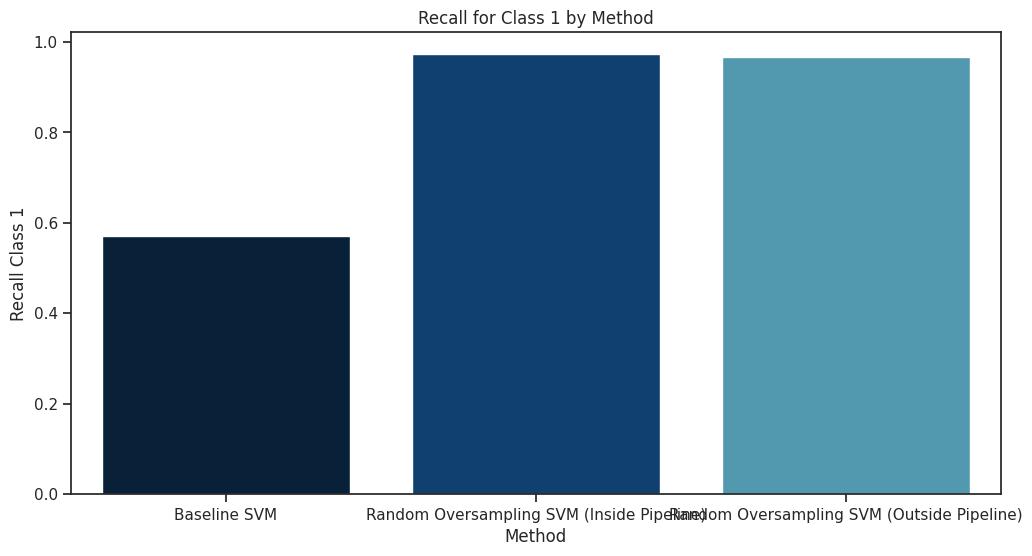

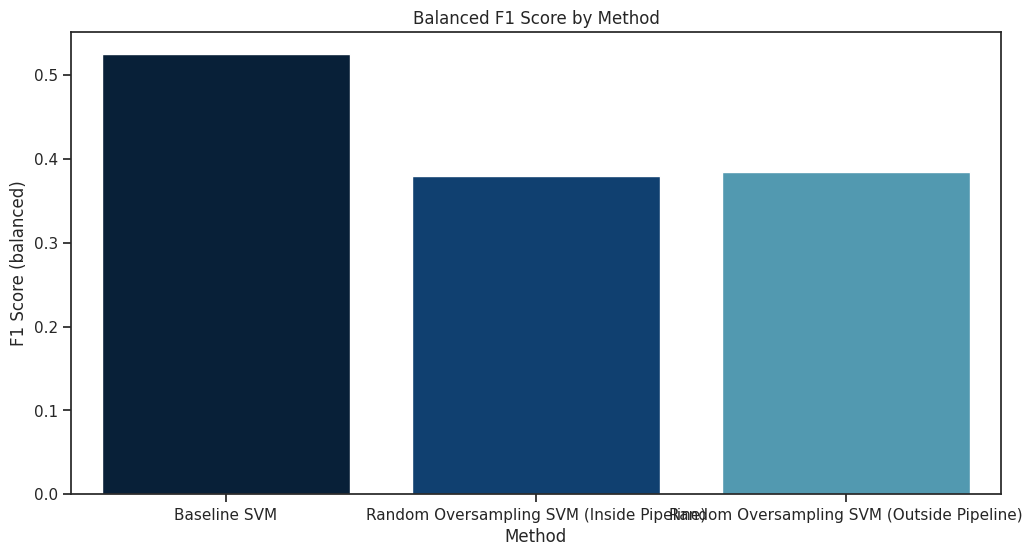

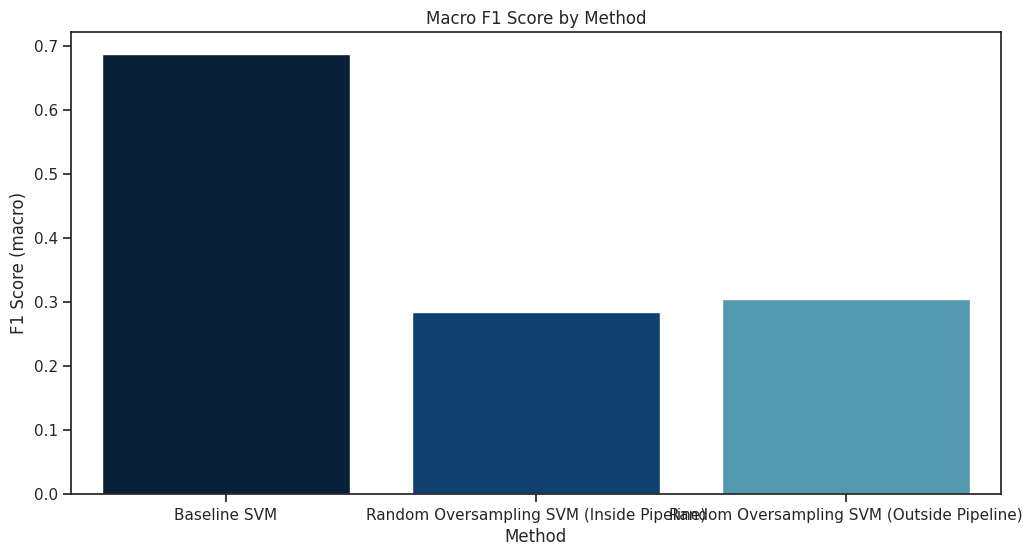

In [8]:
# Combine the results into a single DataFrame
results_df_svm = pd.DataFrame([baseline_results_svm, resampled_results_inside_svm, resampled_results_outside_svm])

# Function to plot the performance metrics for combined results
def plot_combined_metrics(results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Method', data=results_df, palette='ocean', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    plt.show()

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Method', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Method', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(results_df_svm, metric, title, ylabel)


In [9]:
# Display the combined results
print("Combined Performance Metrics:")
results_df_svm

Combined Performance Metrics:


,Method,Recall Class 1,F1 Score (balanced),F1 Score (macro),Threshold
0,Baseline SVM,0.571967,0.525078,0.687174,Optimal (0.25)
1,Random Oversampling SVM (Inside Pipeline),0.972871,0.379985,0.285286,Optimal (0.25)
2,Random Oversampling SVM (Outside Pipeline),0.967596,0.384144,0.304772,Optimal (0.25)


### Interpretation of SVM Results

We experimented with three different setups to improve the recall of the minority class (loan defaults) in our classification task using a Support Vector Machine (SVM) model. The results are summarized as follows:


### Detailed Analysis

1. **Baseline SVM**:
   - **Recall Class 1**: 0.571967
   - **F1 Score (balanced)**: 0.525078
   - **F1 Score (macro)**: 0.687174

   The baseline SVM model achieves a recall of approximately 0.57 for the minority class (class 1), indicating that it correctly identifies 57% of actual defaults. The balanced F1 score and macro F1 score are relatively high, showing a good balance between precision and recall and overall performance across both classes.

2. **Random Oversampling SVM (Inside Pipeline)**:
   - **Recall Class 1**: 0.972871
   - **F1 Score (balanced)**: 0.379985
   - **F1 Score (macro)**: 0.285286

   When random oversampling is applied inside the pipeline, the recall for class 1 improves significantly to approximately 0.97. This indicates that the model is now correctly identifying 97% of actual defaults. However, the balanced F1 score and macro F1 score drop considerably compared to the baseline, indicating that the precision of the model has decreased significantly, leading to a higher number of false positives.

3. **Random Oversampling SVM (Outside Pipeline)**:
   - **Recall Class 1**: 0.967596
   - **F1 Score (balanced)**: 0.384144
   - **F1 Score (macro)**: 0.304772

   Applying random oversampling outside the pipeline yields similar results to the inside pipeline approach, with a slight decrease in recall to approximately 0.97. The balanced F1 score and macro F1 score remain slightly higher than the inside pipeline method but are still significantly lower than the baseline, suggesting a similar issue with a high number of false positives.

### Interpretation

- **High Recall with Resampling**: Both resampling methods (inside and outside the pipeline) significantly improve the recall for the minority class compared to the baseline model. This indicates that oversampling helps the SVM model better identify loan defaults.
- **Decrease in F1 Scores**: The drop in balanced F1 and macro F1 scores suggests a trade-off between improving recall and maintaining precision. The model becomes much better at identifying defaults but misclassifies more non-defaults as defaults, leading to lower precision.
- **Similar Performance for Resampling Methods**: The similar performance of resampling inside and outside the pipeline suggests that the choice between these methods may not have a significant impact on the SVM model's performance for this dataset.

### Recommendations

1. **Evaluate Business Impact**: Consider the business implications of high recall versus balanced performance. If identifying every possible default is critical, the high recall achieved through resampling might be beneficial. However, if the cost of false positives is high, this trade-off may not be acceptable.
2. **Further Model Tuning**: To improve both recall and precision, perform hyperparameter tuning for the SVM model using techniques like grid search or randomized search. Adjust parameters such as the regularization parameter `C` and the kernel type.
3. **Explore Other Models and Techniques**: Given the high recall but poor precision, explore other models like ensemble methods (e.g., Random Forests, Gradient Boosting) that might better handle the class imbalance. Additionally, consider using other resampling techniques such as SMOTE or ADASYN, which might provide a better balance.
4. **Use Threshold Adjustment**: Experiment with different decision thresholds to find a balance between recall and precision that suits your business needs.

### Summary

- **High Recall, Low Precision**: Resampling significantly improves recall but at the cost of precision.
- **Model Tuning and Alternative Methods**: Further tuning and exploring other models or resampling techniques might yield better overall performance.
- **Business Considerations**: The choice of model and method should be guided by the business impact of false positives versus the importance of identifying defaults.


Data leakage is indeed a critical consideration when resampling data outside the pipeline. To avoid data leakage, we need to ensure that resampling is applied only to the training data and not to the test data. Let's re-examine the process to ensure we are doing this correctly.

### Ensuring No Data Leakage with Resampling Outside the Pipeline

1. **Splitting Data First**: Always split the data into training and testing sets before any resampling is applied.
2. **Applying Resampling Only to Training Data**: Apply the SMOTE (or any resampling technique) only to the training set.

### Write Loan Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
